# Clustering model

In [1]:
# Import the packages

from scipy import cluster, spatial
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

import numpy as np
import pandas as pd
import timeit
import math

from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib.patches as mpatches
import seaborn as sns
import colorcet as cc

In [2]:
# Set the parameters
timeframe = 'coldest_day'
max_d = 40 # Distance can be retrieved from a dendrogram
cmax = 3000
cmin = 1000
rad = 100

In [3]:
# Import the dataframe
df = pd.read_csv('data/residential_and_wh_total_innercity.csv')

In [4]:
# Convert the dataframe to the right format
x = df['x'].tolist()
y = df['y'].tolist()
energy = df[timeframe].tolist()
street = df['postcode'].tolist()

d = {'x':x, 'y':y}
data = pd.DataFrame(d)
X = data.values

In [5]:
len(X)

57453

In [6]:
# Execute single linkage clustering
Z = cluster.hierarchy.linkage(X, "single")
clusters = fcluster(Z, max_d, criterion='distance')

In [7]:
x,y=np.split(X,2,axis=1)

x = x.flatten()
y = y.flatten()

# Create a dataframe with the clusters
df = pd.DataFrame ({'x':x,'y':y,'clusters':clusters, 'energy':energy, 'street':street})

In [8]:
# Add aditional columns to the dataframe and create an extra dataframe specifically for ZIP codes
def create_df_per_ZIP(df):
    df2= df.copy()

    df2['energy_ZIP'] = 0
    df['energy_ZIP'] = 0
    df2['total_energy'] = 0

    for i in df2.street.unique():
        df2['energy_ZIP'].loc[df2['street'] == i] = df2['energy'].loc[df2['street'] == i].sum()
        df['energy_ZIP'].loc[df['street'] == i] = df['energy'].loc[df['street'] == i].sum()

    for i in df2.clusters.unique():
        df2['total_energy'].loc[df2['clusters'] == i] = df2['energy'].loc[df2['clusters'] == i].sum()

    df2.drop(['x', 'y', 'energy'], axis=1, inplace=True)
    df2.drop_duplicates(inplace=True)
    
    #df2['centers'] = 0
    #for i in df2.clusters.unique():
     #   arr_x = []
     #   arr_y = []
     #   for index, row in df.loc[df.clusters == i].iterrows():
     #       arr_x.append(row.x)
     #       arr_y.append(row.y)
     #   arr_x = np.array(arr_x)
     #   arr_y = np.array(arr_y)

     #   center = (max(arr_x)+min(arr_x))/2., (max(arr_y)+min(arr_y))/2
     #   df2.loc[df2.clusters == i, 'centers'] = str(center)
        
    df['clust_street'] = np.nan
    for i in range(len(df)):
        df.loc[i, 'clust_street'] = str(df.loc[i, 'clusters']) + ', ' + str(df.loc[i, 'street'])
        
    df['Building type'] = np.nan
    for i in range(len(df)):
        if df.loc[i, 'energy'] > 0:
            df.loc[i, 'Building type'] = 'Non-residential'
        else:
            df.loc[i, 'Building type'] = 'Residential'
        
    df['Absolute energy in MWh'] = np.nan
    for i in range(len(df)):
        df.loc[i, 'Absolute energy in MWh'] = abs(df.loc[i, 'energy']) / 1000
        
    return df, df2

df, df2 = create_df_per_ZIP(df)

C:\Users\sarah\AppData\Local\Temp\ipykernel_17176\44317002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['energy_ZIP'].loc[df2['street'] == i] = df2['energy'].loc[df2['street'] == i].sum()
C:\Users\sarah\AppData\Local\Temp\ipykernel_17176\44317002.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['energy_ZIP'].loc[df['street'] == i] = df['energy'].loc[df['street'] == i].sum()
C:\Users\sarah\AppData\Local\Temp\ipykernel_17176\44317002.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

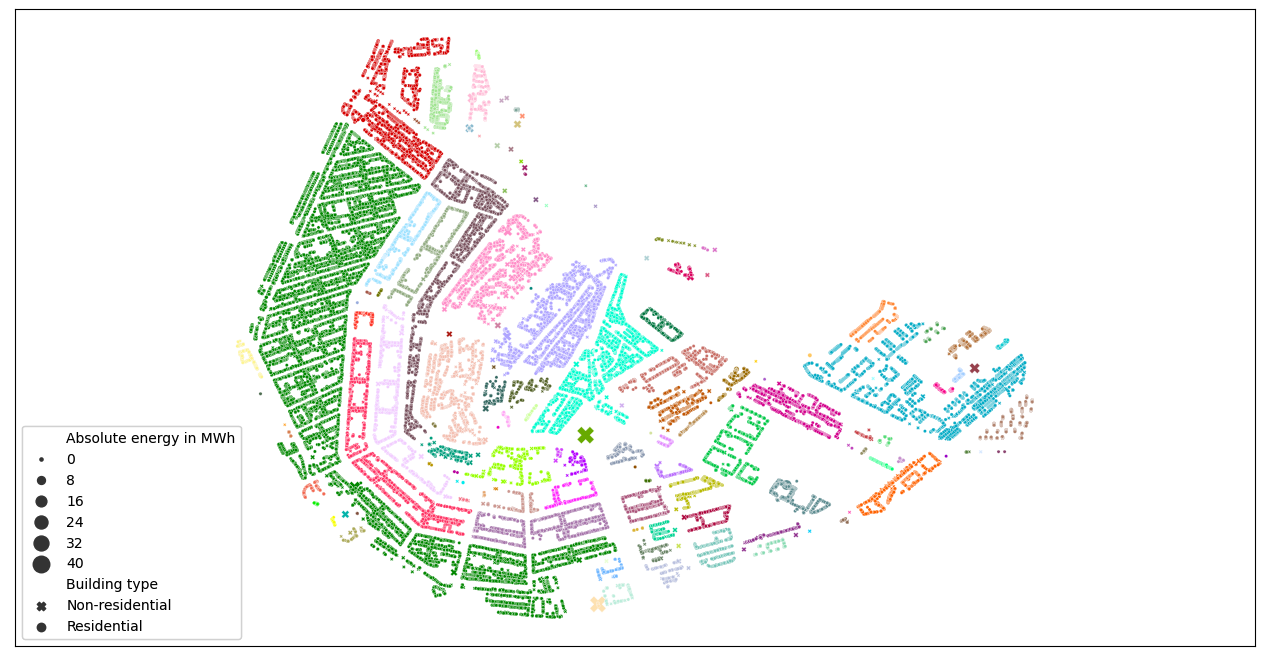

In [9]:
# Create a plot of the clusters identified with Single Linkage clustering

palette = sns.color_palette(cc.glasbey_light, n_colors=len(df.clusters.unique()))

plt.figure(figsize=(16,8.27))

_clusters= list(df.clusters.unique())
g=sns.scatterplot(data=df, x='x', y='y', hue='clusters', hue_order=_clusters, palette=palette, style='Building type', \
                  size='Absolute energy in MWh', sizes=(5, 150), markers = {'Non-residential': 'X', 'Residential': 'o'})

h,l = g.get_legend_handles_labels()
plt.legend(h[0:13],l[0:13],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.margins(x = 0.28)

g.get_xaxis().set_visible(False)
g.get_yaxis().set_visible(False)

h,l = g.get_legend_handles_labels()
legend2 = plt.legend(h[len(df.clusters.unique())+1:len(h)],l[len(df.clusters.unique())+1:len(h)],loc='lower left')

plt.gca().add_artist(legend2)

plt.show(g)

In [10]:
df.clusters.value_counts()

118    17139
27      3823
117     3189
85      3144
80      2804
       ...  
39         1
6          1
123        1
4          1
112        1
Name: clusters, Length: 130, dtype: int64

In [11]:
# Split clusters
def split_cluster(df, cluster_id):
    count = 0
    z = df.clusters.unique().max()
    # Create a dataframe of this cluster
    too_big = df.loc[(df['clusters'] == cluster_id)]
    
    # Prepare data to use single linkage clustering
    x = too_big['x'].tolist()
    y = too_big['y'].tolist()
    d2 = {'x':x,'y':y}
    data2 = pd.DataFrame(d2)
    X2 = data2.values

    # Split the cluster into k based on single linkage clustering
    Z2 = cluster.hierarchy.linkage(X2, "single")
    clusters2 = fcluster(Z2, 2, criterion='maxclust')
    
    # Change the values of the new clusters 
    for j in range(1,3):
        if j == 2:
            clusters2[clusters2 == j] = cluster_id
        else:
            count +=1
            clusters2[clusters2 == j] = z+count

    # Update the dataframe with the new cluster values
    too_big['clusters'] = clusters2
    df.update(too_big)
    
    return df

In [12]:
# Find the closest cluster based on the Single Linkage distance
def find_nearest_cluster(df, cluster_index, closest_distance=math.inf):
    
    clustera = df.loc[(df['clusters'] == cluster_index)]
    rest = df.loc[(df['clusters'] != cluster_index)]
    
    Q = pd.DataFrame({'x':rest.x,'y':rest.y}).values

    for j in range(len(clustera)):
        x = clustera.iloc[j]['x']
        y = clustera.iloc[j]['y']
        distance, index = spatial.KDTree(Q).query([x, y])

        if distance < closest_distance:
            closest_distance = distance
            closest_cluster = rest.iloc[index,2]
            pointx = rest.iloc[index,0]
            pointy = rest.iloc[index,1]
            
    return closest_cluster, clustera, pointx, pointy

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'
# Split clusters that exceed cmax
def split_large_clusters(df, cmax):

    # While one of the clusters is larger then cmax
    while df.clusters.value_counts().max() > cmax:
        # Loop trough the clusters
        for i in df.clusters.unique():

            # If this cluster is larger then cmax
            if len(df.loc[(df['clusters'] == i)]) > cmax:

                df = split_cluster(df, cluster_id=i)
        
    return df

In [14]:
# Merge clusters below cmin
def join_small_clusters(df, cmin, cmax):
    while df.clusters.value_counts().min() < cmin:

    # Loop trough the clusters
        for i in df.clusters.unique():
            
            # If this cluster is larger then cmax
            if len(df.loc[(df['clusters'] == i)]) < cmin:
                #print('te klein cluster: ',i)
                closest_cluster, clustera, pointx, pointy = find_nearest_cluster(df, i)

                df['clusters'] = df['clusters'].replace([i], closest_cluster)

    return(df)

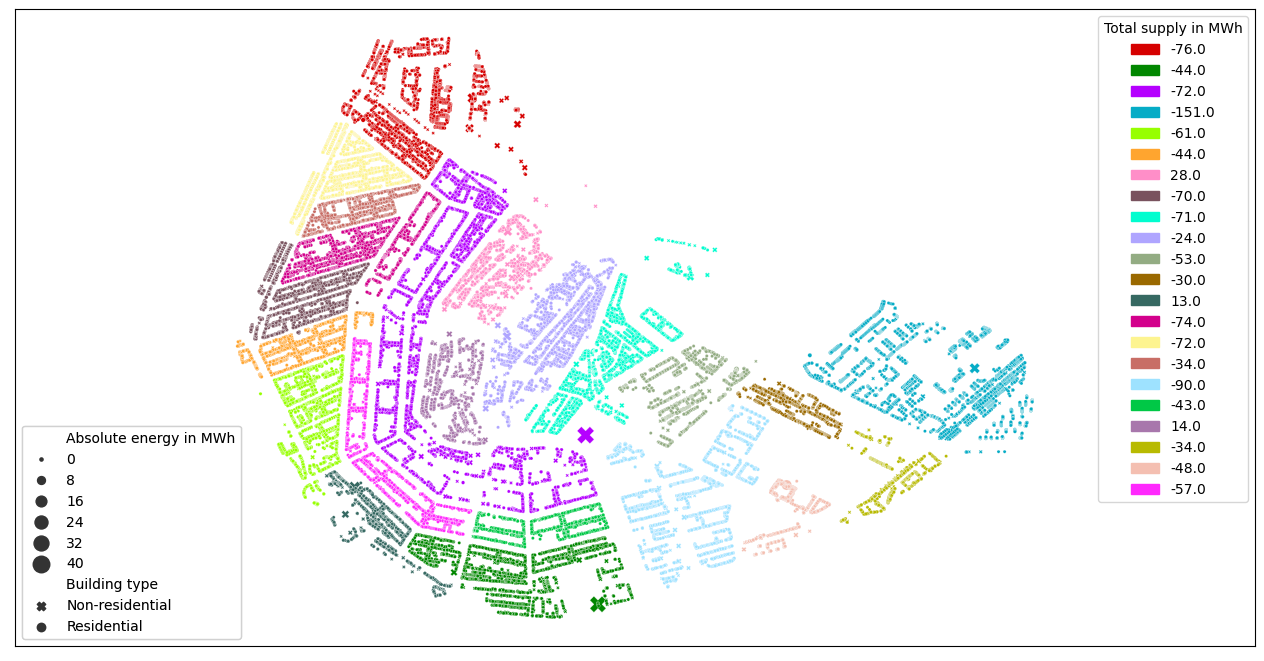

Time:  361.41734949999955


In [15]:
start = timeit.default_timer()

# Provide the adjustments according to size
df = split_large_clusters(df, cmax)
df = join_small_clusters(df, cmin, cmax)
df, df2 = create_df_per_ZIP(df)
df.to_csv('results/outcome_bc_2')

# Plot the clusters adjusted by size
palette = sns.color_palette(cc.glasbey_light, n_colors=len(df.clusters.unique()))

plt.figure(figsize=(16,8.27))

_clusters= list(df.clusters.unique())
g=sns.scatterplot(data=df, x='x', y='y', hue='clusters', hue_order=_clusters, palette=palette, style='Building type', \
                  size='Absolute energy in MWh', sizes=(5, 150), markers = {'Non-residential': 'X', 'Residential': 'o'})

h,l = g.get_legend_handles_labels()
plt.legend(h[0:13],l[0:13],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.margins(x = 0.28)

g.get_xaxis().set_visible(False)
g.get_yaxis().set_visible(False)

l = list(df2.clusters.unique())
patches = [ mpatches.Patch(color = sns.color_palette([palette[l.index(i)]]).as_hex()[0], label=round((df2.loc[df2.clusters == i, 
                                                                                                        'total_energy']/1000),0).iat[0]) for i in l ]
legend1 = plt.legend(handles=patches,title='Total supply in MWh', loc='upper right')
h,l = g.get_legend_handles_labels()
legend2 = plt.legend(h[len(df.clusters.unique())+1:len(h)],l[len(df.clusters.unique())+1:len(h)],loc='lower left')

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.savefig('results/outcome_bc.png', dpi=1200)
plt.show(g)

stop = timeit.default_timer()

print('Time: ', stop - start)

In [16]:
df.clusters.value_counts()

140.0    5850
101.0    5285
117.0    4743
134.0    3818
53.0     3625
80.0     3146
135.0    3037
144.0    2892
141.0    2796
142.0    2776
147.0    2672
65.0     2247
78.0     2029
145.0    1875
105.0    1802
139.0    1425
146.0    1402
60.0     1362
76.0     1310
45.0     1193
106.0    1102
35.0     1066
Name: clusters, dtype: int64

In [17]:
# Calculate the shortest distance possible between two points in two dataframes 
def cal_dis(dfA, dfB):
    x_A = dfA["x"].values
    y_A = dfA["y"].values
    x_B = dfB["x"].values
    y_B = dfB["y"].values

    x_diff = np.square(x_B[:, np.newaxis] - x_A)
    y_diff = np.square(y_B[:, np.newaxis] - y_A)
    dist_matrix = np.sqrt(x_diff + y_diff)

    index_storage = np.argmin(dist_matrix, axis=0)
    value_storage = np.min(dist_matrix, axis=0)

    idx_B = index_storage.astype(int)
    idx_A = np.arange(len(dfA))

    min_dist = np.min(value_storage)
    min_idxA = np.argmin(value_storage)
    min_idxB = idx_B[np.argmin(value_storage)]
    return min_dist, min_idxA, min_idxB

In [20]:
def optimize_clusters(df, df2, rad):
    # Set possibility true
    possibility = True
    new = []
    # Whilst there is still an adjustment available
    while possibility is True:
        # Reset the variables that define the clusters with the closest distance
        closest_distance = clust_1 = clust_2 = math.inf
        
        # If all clusters have sufficient supply, stop the algorithm
        if df2.total_energy.min() > 0: 
            possibility = False
            break
            
        # Select the clusters with a lack of supply
        neg = df2.loc[df2.total_energy <= 0, 'clusters'].unique()
        for cluster_id in neg:

            # Select the clusters with a sufficient supply
            pos = df2.loc[df2.total_energy > 0, 'clusters'].unique()
            for cluster2_id in pos: 
                
                # If cluster 1 is larger, then it needs to give away a street with a lack of supply
                if len(df.loc[df.clusters == cluster_id]) > len(df.loc[df.clusters == cluster2_id]):
                    # Create one dataframe with the buildings in cluster and ZIP codes that both have a negative energy balance
                    ZIP1 = df.loc[(df.energy_ZIP < 0) & (df.clusters == cluster_id)] 
                    # Create another dataframe with the buildings in a cluster with enough supply and that have not been switched before
                    ZIP2 = df.loc[(df.clusters == cluster2_id) & (~df.clust_street.isin(new))]  #
                
                # If cluster 1 is smaller, then it needs a street from cluster 2 with sufficient supply
                else:
                    # Create one dataframe with the buildings in cluster and ZIP codes that both have a positive energy balance
                    ZIP1 = df.loc[(df.energy_ZIP > 0) & (df.clusters == cluster2_id)]
                    # Create another dataframe with the buildings in a cluster with a lack of supply and that have not been switched before
                    ZIP2 = df.loc[(df.clusters == cluster_id) & (~df.clust_street.isin(new))]  #
                
                #if ZIP1.empty:
                 #   continue
                
                # Search voor the the two points in two different clusters that are the closest together
                min_dist, min_idxA, min_idxB = cal_dis(ZIP1, ZIP2)
                
                # When this distance is less then rad and is closer than was identified between previous cluster, continue
                if min_dist < closest_distance and min_dist < rad:
                    # Calculate the sum of the absolute energy balance of both clusters
                    clust_sum = abs(df2.total_energy.loc[df2.clusters == cluster_id].iat[0]) \
                                    + abs(df2.total_energy.loc[df2.clusters == cluster2_id].iat[0])
                    # Calculate the absolute energy balance when a street is switched between the clusters
                    if len(df.loc[df.clusters == cluster_id]) > len(df.loc[df.clusters == cluster2_id]):
                        clust_sum2 = abs(df2.total_energy.loc[df2.clusters == cluster_id].iat[0] - ZIP1.iloc[min_idxA, 5]) \
                                        + abs(df2.total_energy.loc[df2.clusters == cluster2_id].iat[0] + ZIP1.iloc[min_idxA, 5])
                    else:
                        clust_sum2 = abs(df2.total_energy.loc[df2.clusters == cluster_id].iat[0] + ZIP1.iloc[min_idxA, 5]) \
                                        + abs(df2.total_energy.loc[df2.clusters == cluster2_id].iat[0] - ZIP1.iloc[min_idxA, 5])
                    # If the switch is an improvement, continue
                    if clust_sum2 < clust_sum:
                        # Save new distance
                        closest_distance = min_dist
                        # Save the cluster id's and ZIP code
                        clust_1 = cluster_id
                        clust_2 = cluster2_id
                        ZIPcode = ZIP1.iloc[min_idxA, 4]
                        ZIPcode2 = ZIP2.iloc[min_idxB, 4]
                                
        # If there is found a possible adjustment that reduces the average absolute difference in supply, continue
        if closest_distance != math.inf:
            print(clust_1,' | ',clust_2, ' | ',closest_distance, ' | ', ZIPcode, ' | ', ZIPcode2)
            
            # If cluster 1 gives a street away, change the dataframe
            if len(df.loc[df.clusters == clust_1]) > len(df.loc[df.clusters == clust_2]):
                df['clusters'].loc[(df.street == ZIPcode) & (df.clusters == clust_1)] = clust_2
                df, df2 = create_df_per_ZIP(df)
                # Add this switched street to the list
                new.append(df['clust_street'].loc[(df.street == ZIPcode) & (df.clusters == clust_2)].iat[0])
                
            # If cluster 1 takes over a street, change the dataframe
            else:
                df['clusters'].loc[(df.street == ZIPcode) & (df.clusters == clust_2)] = clust_1
                df, df2 = create_df_per_ZIP(df)
                # Add this switched street to the list
                new.append(df['clust_street'].loc[(df.street == ZIPcode) & (df.clusters == clust_1)].iat[0])

            print(sum([abs(number) for number in df2.total_energy.unique()]))

        # If no possible adjustment is found, set possibility false
        else:
            possibility = False
    
    return(df, df2)

In [21]:
start = timeit.default_timer()
        
df, df2 = optimize_clusters(df, df2, rad)

stop = timeit.default_timer()

print('Time: ', stop - start)

142.0  |  139.0  |  38.897300677553446  |  1016CS  |  1017ND
1202203.8537123841
142.0  |  139.0  |  38.91015291668744  |  1016CR  |  1017NC
1199074.7297117242
135.0  |  139.0  |  39.20459156782532  |  1017JP  |  1017JR
1198558.459380886
135.0  |  139.0  |  39.942316280093685  |  1017KR  |  1017JR
1196966.1216708208
142.0  |  139.0  |  40.266117340855885  |  1016CT  |  1017ND
1196718.7423753177
135.0  |  139.0  |  41.91331441200693  |  1017RN  |  1017SP
1194714.0135589475
80.0  |  78.0  |  43.266615305567875  |  1012JV  |  1012ZJ
1192875.667385116
135.0  |  139.0  |  45.221676218380054  |  1017SM  |  1017SP
1191907.486527896
105.0  |  139.0  |  47.634021455258214  |  1017JW  |  1017KE
1188642.0061509896
105.0  |  139.0  |  48.010415536631214  |  1017JZ  |  1017KJ
1185108.6064759232
105.0  |  139.0  |  48.104053883222775  |  1017JX  |  1017KH
1183442.920574333
80.0  |  76.0  |  48.66971750629078  |  1012KL  |  1012KW
1182626.1134783332
135.0  |  139.0  |  48.82622246293481  |  1017SP  | 

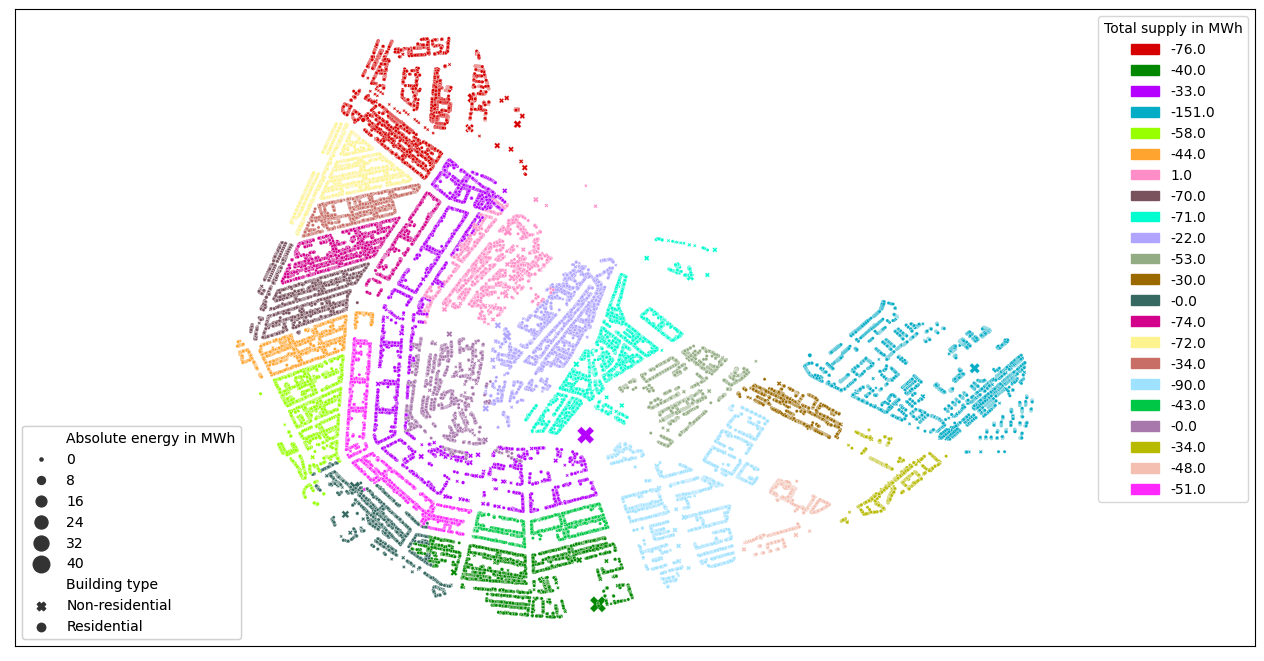

In [22]:
# Plot the clusters adjusted with the optimization function

palette = sns.color_palette(cc.glasbey_light, n_colors=len(df.clusters.unique()))

plt.figure(figsize=(16,8.27))

#_clusters= list(df.clusters.unique())
g=sns.scatterplot(data=df, x='x', y='y', hue='clusters', hue_order=_clusters, palette=palette, style='Building type', \
                  size='Absolute energy in MWh', sizes=(5, 150), markers = {'Non-residential': 'X', 'Residential': 'o'})

h,l = g.get_legend_handles_labels()
plt.legend(h[0:13],l[0:13],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.margins(x = 0.28)

g.get_xaxis().set_visible(False)
g.get_yaxis().set_visible(False)

l = list(df2.clusters.unique())
patches = [ mpatches.Patch(color = sns.color_palette([palette[l.index(i)]]).as_hex()[0], label=round((df2.loc[df2.clusters == i, 
                                                                                                        'total_energy']/1000),0).iat[0]) for i in l ]
legend1 = plt.legend(handles=patches,title='Total supply in MWh', loc='upper right')
h,l = g.get_legend_handles_labels()
legend2 = plt.legend(h[len(df.clusters.unique())+1:len(h)],l[len(df.clusters.unique())+1:len(h)],loc='lower left')

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.savefig('results/outcome_cd.png', dpi=1200)
plt.show(g)

In [23]:
df.clusters.value_counts()

140.0    5850
117.0    4743
101.0    4134
134.0    3818
53.0     3625
80.0     3085
135.0    2905
144.0    2892
141.0    2796
78.0     2750
142.0    2695
147.0    2672
65.0     2247
145.0    1875
76.0     1801
139.0    1758
105.0    1682
146.0    1402
60.0     1362
45.0     1193
106.0    1102
35.0     1066
Name: clusters, dtype: int64

In [24]:
df.to_csv('results/outcome_cd')

Inspiration for the optimize_clusters function is provided by:
https://www.kaggle.com/code/barelydedicated/hierarchical-clustering-single-link